**Random Forest Classifier**

Library imports

In [5]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier

sys.path.insert(0, str(Path.cwd().parent))

Data Imports

In [2]:
from utils.utils import save_experiment, train_and_evaluate_random_forest, grid_search_joblib
from configs.config_local import DATASET_PATH, ITW_DATASET_PATH, FEATURES_DIR

Training / Validation / Test features:
Using mean aggregated, N_MFCC = 20, N_FTT = 128, HOP_LENGTH = 256, N_MELS = 128

In [3]:
train_path = os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet")
val_path = os.path.join(FEATURES_DIR, "validation_features_mean_20_128_256_128.parquet")
test_path = os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128.parquet")

Training with default hyperparameters

In [4]:
pipeline, metrics, rf_params, feature_names, metadata_extra, oob_score = train_and_evaluate_random_forest(
    train_path=train_path,
    val_path=val_path,
    test_path=None,  # No test path, so validation metrics will use standard keys
)

print("Metadata:", metadata_extra)
print("Metrics:", metrics)
print(f"OOB Score: {oob_score:.4f}")

Training on 53868 samples with 195 features...
Metadata: {'train_samples': 53868, 'val_samples': 10798}
Metrics: {'accuracy': 0.9930542693091313, 'precision': 0.9930974177832339, 'recall': 0.9930551438804496, 'f1': 0.9930541262773995, 'roc_auc': 0.999767798087083}
OOB Score: 0.9926


Feature Importance

Top 10 Features:
                      Feature  Importance
20          mfcc_delta_mean_0    0.041944
193  mel_spectrogram_mean_126    0.039408
192  mel_spectrogram_mean_125    0.038787
68     mel_spectrogram_mean_1    0.036927
60                rmse_mean_0    0.033801
76     mel_spectrogram_mean_9    0.033244
75     mel_spectrogram_mean_8    0.029214
43         mfcc_delta2_mean_3    0.028809
74     mel_spectrogram_mean_7    0.027607
70     mel_spectrogram_mean_3    0.023274


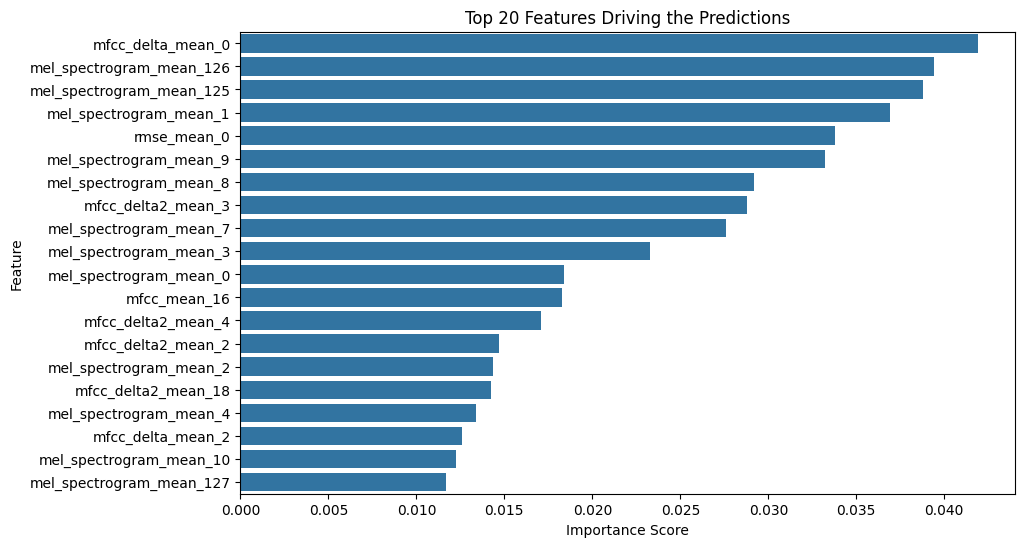

In [6]:
# 1. Extract Feature Importances from the Pipeline
# We need to access the 'rf' step inside the pipeline
rf_model = pipeline.named_steps['rf']
importances = rf_model.feature_importances_

# 2. Create a DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Print Top 10
print("Top 10 Features:")
print(feature_imp_df.head(10))

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20))
plt.title('Top 20 Features Driving the Predictions')
plt.xlabel('Importance Score')
plt.show()

In [ ]:
if oob_score is not None:
    metrics["oob_score"] = float(oob_score)

# 3. Save the Experiment
saved_path = save_experiment(
    model=pipeline,
    metrics=metrics,
    experiment_dir="experiments",
    experiment_name="RF_Baseline_Audio_v1",
    model_params=rf_params,
    feature_names=feature_names,
    metadata_extra=metadata_extra
)

Experiment saved to: experiments/RF_Baseline_Audio_v1


In [ ]:
clf, metrics, rf_params, feature_names, metadata_extra = train_and_evaluate_random_forest(
    train_path=train_path,
    val_path=test_path,
    test_path=None,
)
print(metadata_extra)
print(metrics)

Training with default hyperparameters using Entropy

In [ ]:
clf, metrics, rf_params, feature_names, metadata_extra = train_and_evaluate_random_forest(
    train_path=train_path,
    val_path=val_path,
    test_path=None,
    criterion="entropy"
)
print(metadata_extra)
print(metrics)

Training with weighted fake class

In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 11,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "random_state": 42,
    "class_weight": {0: 1, 1: 5}
}

clf, metrics, rf_params, feature_names, metadata_extra = train_and_evaluate_random_forest(
    train_path=train_path,
    val_path=None,
    test_path=test_path,
    criterion="gini",
    rf_params=params
)
print(metadata_extra)
print(metrics)

**Validate using the ITW Dataset**

In [ ]:
itw_val_path = os.path.join(ITW_DATASET_PATH, "normalized_features", "itw_features_20_128_256_128_trimmed_loudness_normalized.parquet")

In [ ]:
clf, metrics, rf_params, feature_names, metadata_extra = train_and_evaluate_random_forest(
    train_path=train_path,
    val_path=itw_val_path,
    test_path=None,
    criterion="gini"
)
print(metadata_extra)
print(metrics)

Validation using weighted fake class on ITW

In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 13,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "random_state": 42,
    "class_weight": {0: 1, 1: 5}
}

clf, metrics, rf_params, feature_names, metadata_extra = train_and_evaluate_random_forest(
    train_path=train_path,
    val_path=itw_val_path,
    test_path=None,
    criterion="gini",
    rf_params=params
)
print(metadata_extra)
print(metrics)

**Hyperparameter Grid Search**

In [ ]:
model = RandomForestClassifier(random_state=42)

params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [8, 10, 12, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [{0: 1, 1: 5}, None],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2"],
}

(
    final_model,
    test_metrics,
    val_metrics,
    best_params,
    val_results,
    metadata,
    feature_names
) = grid_search_joblib(
    model=model,
    param_grid=params,
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    scoring="f1_macro",
    verbose=1,
    n_jobs=-1
)

In [ ]:
save_experiment(
    final_model,
    test_metrics,
    experiment_dir=os.path.join("experiments", "RF_grid"),
    model_params=best_params,
    feature_names=feature_names,
    metadata_extra=metadata,
    val_results=val_results,
)